# **Setting up the Environment**

In [1]:
!pip install transformers

!pip install pycaret

# **Loading the Dataset**

In [2]:
import numpy as np
import pandas as pd
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

device = torch.device("cuda")

In [3]:
true_data = pd.read_csv('a1_True.csv')
fake_data = pd.read_csv('a2_Fake.csv')

true_data['Target'] = ['True']*len(true_data)
fake_data['Target'] = ['Fake']*len(fake_data)

data = true_data.append(fake_data).sample(frac=1).reset_index().drop(columns=['index'])

print(data.shape)
data.head()

(44898, 5)


,title,text,subject,date,Target
0,Major Advertiser DROPS Breitbart For Racist C...,"Breitbart News, the right wing hate site that ...",News,"November 29, 2016",Fake
1,BREAKING: NO CHARGES For Police Officer In Sho...,Riots erupted in Charlotte after police office...,politics,"Nov 30, 2016",Fake
2,WOW! RUSSIAN HACKER Gives Stunning Details Of ...,A Russian man wanted by the Justice Department...,left-news,"May 12, 2017",Fake
3,JOHN KERRY BREAKS LEG IN BIKE CRASH IN FRENCH ...,"Fortunately, our useless Secretary of State Jo...",politics,"May 31, 2015",Fake
4,Catalonia government says 893 injured in clash...,MADRID (Reuters) - The Catalan health service ...,worldnews,"October 2, 2017",True


In [4]:
data['label'] = pd.get_dummies(data.Target)['Fake']

In [5]:
data.head()

,title,text,subject,date,Target,label
0,Major Advertiser DROPS Breitbart For Racist C...,"Breitbart News, the right wing hate site that ...",News,"November 29, 2016",Fake,1
1,BREAKING: NO CHARGES For Police Officer In Sho...,Riots erupted in Charlotte after police office...,politics,"Nov 30, 2016",Fake,1
2,WOW! RUSSIAN HACKER Gives Stunning Details Of ...,A Russian man wanted by the Justice Department...,left-news,"May 12, 2017",Fake,1
3,JOHN KERRY BREAKS LEG IN BIKE CRASH IN FRENCH ...,"Fortunately, our useless Secretary of State Jo...",politics,"May 31, 2015",Fake,1
4,Catalonia government says 893 injured in clash...,MADRID (Reuters) - The Catalan health service ...,worldnews,"October 2, 2017",True,0


([<matplotlib.patches.Wedge at 0x7a1f83ba4910>,
 [Text(-1.1968727067385088, -0.0865778485782335, 'Fake'),
  Text(1.1968726986325005, 0.08657796063754254, 'True')],
 [Text(-0.6981757455974634, -0.05050374500396954, '52.3%'),
  Text(0.6981757408689586, 0.05050381037189981, '47.7%')])

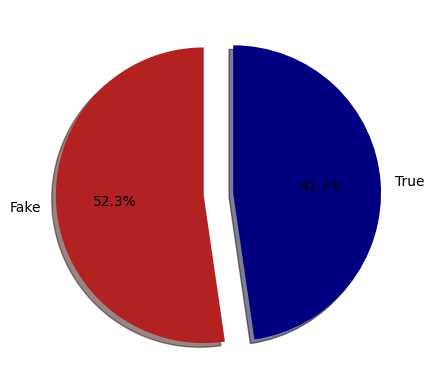

In [6]:
label_size = [data['label'].sum(), len(data['label'])-data['label'].sum()]
plt.pie(label_size, explode=[0.1, 0.1], colors=['firebrick', 'navy'], startangle=90, shadow=True, labels=['Fake', 'True'], autopct='%1.1f%%')

# **Train-Test-Splitting**

In [7]:
train_text, temp_text, train_labels, temp_labels = train_test_split(data['title'],
                                                                    data['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=data['Target'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text,
                                                                temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

# **BERT Fine-Tuning**

## Loading BERT Model

In [8]:
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## Preparing Input Data

Text(0, 0.5, 'Number of texts')

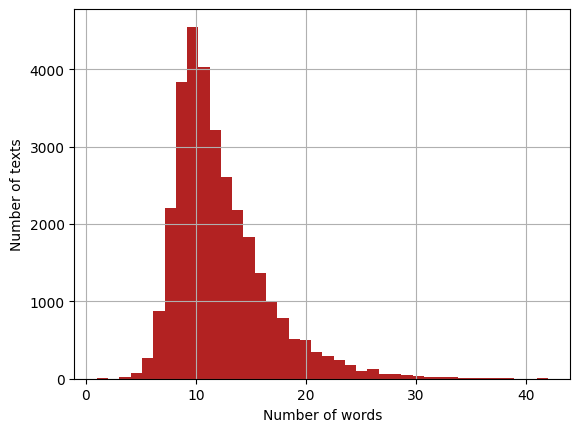

In [9]:
seq_len = [len(title.split()) for title in train_text]

pd.Series(seq_len).hist(bins=40, color='firebrick')
plt.xlabel('Number of words')
plt.ylabel('Number of texts')

In [10]:
sample_data = ["Build fake news model.", "Using BERT."]
tokenized_sample_data = tokenizer.batch_encode_plus(sample_data, padding=True)
print(tokenized_sample_data)

{'input_ids': [[101, 3857, 8275, 2739, 2944, 1012, 102], [101, 2478, 14324, 1012, 102, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 0, 0]]}


In [11]:
MAX_LENGTH = 15

tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length=MAX_LENGTH,
    pad_to_max_length=True,
    truncation=True
)

tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length=MAX_LENGTH,
    pad_to_max_length=True,
    truncation=True
)

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length=MAX_LENGTH,
    pad_to_max_length=True,
    truncation=True
)

In [12]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [13]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

## Freezing Layers

In [14]:
for param in bert.parameters() :
  param.requires_grad = False

## Defining the Model Architecture

In [15]:
class BERT_Arch(nn.Module) :
    def __init__(self, bert) :
      super(BERT_Arch, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1)
      self.relu = nn.ReLU()
      self.fc1 = nn.Linear(768, 512)
      self.fc2 = nn.Linear(512, 2)
      self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, sent_id, mask) :
      cls_hs = self.bert(sent_id, attention_mask=mask)

      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)
      x = self.softmax(x)
      return x

    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1)
      self.relu =  nn.ReLU()
      self.fc1 = nn.Linear(768,512)
      self.fc2 = nn.Linear(512,2)
      self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, sent_id, mask):
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']

      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)
      x = self.softmax(x)
      return x

model = BERT_Arch(bert)

from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)

cross_entropy  = nn.NLLLoss()

epochs = 2

## Defining Train and Validation Functions

In [16]:
def train() :
  model.train()
  total_loss, total_accuracy = 0, 0

  for step, batch in enumerate(train_dataloader) :
    if step%50 == 0 and not step == 0 :
      print(' Batch {:>5,} of {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]
    sent_id, mask, labels = batch
    model.zero_grad()
    preds = model(sent_id, mask)
    loss = cross_entropy(preds, labels)
    total_loss = total_loss + loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    preds = preds.detach().cpu().numpy()

  avg_loss = total_loss/len(train_dataloader)

  return avg_loss

def evaluate() :
  print("\nEvaluating...")
  model.eval()
  total_loss, total_accuracy = 0, 0
  for step, batch in enumerate(val_dataloader) :
    if step%50 == 0 and not step == 0 :

      print('Batch {:>5,} of {:>5,}.'.format(step, len(val_dataloader)))

    batch = [t for t in batch]
    sent_id, mask, labels = batch
    with torch.no_grad() :
      preds = model(sent_id, mask)
      loss = cross_entropy(preds, labels)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss/len(val_dataloader)
  return avg_loss

## Model Training

In [18]:
best_valid_loss = float('inf')
train_losses = []
valid_losses = []

for epoch in range(epochs) :
  print('\n Epoch {:} / {:}'.format(epoch+1, epochs))
  train_loss = train()
  valid_loss = evaluate()
  if valid_loss < best_valid_loss :
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'model_dict.pt')
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  print(f'\n Training Loss: {train_loss:.3f}')
  print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2
 Batch    50 of   983.
 Batch   100 of   983.
 Batch   150 of   983.
 Batch   200 of   983.
 Batch   250 of   983.
 Batch   300 of   983.
 Batch   350 of   983.
 Batch   400 of   983.
 Batch   450 of   983.
 Batch   500 of   983.
 Batch   550 of   983.
 Batch   600 of   983.
 Batch   650 of   983.
 Batch   700 of   983.
 Batch   750 of   983.
 Batch   800 of   983.
 Batch   850 of   983.
 Batch   900 of   983.
 Batch   950 of   983.

Evaluating...
Batch    50 of   211.
Batch   100 of   211.
Batch   150 of   211.
Batch   200 of   211.

 Training Loss: 0.491
Validation Loss: 0.424

 Epoch 2 / 2
 Batch    50 of   983.
 Batch   100 of   983.
 Batch   150 of   983.
 Batch   200 of   983.
 Batch   250 of   983.
 Batch   300 of   983.
 Batch   350 of   983.
 Batch   400 of   983.
 Batch   450 of   983.
 Batch   500 of   983.
 Batch   550 of   983.
 Batch   600 of   983.
 Batch   650 of   983.
 Batch   700 of   983.
 Batch   750 of   983.
 Batch   800 of   983.
 Batch   850 of   

## Model Performance

In [19]:
path = 'model_dict.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [20]:
with torch.no_grad() :
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis=1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85      3212
           1       0.89      0.82      0.85      3523

    accuracy                           0.85      6735
   macro avg       0.86      0.86      0.85      6735
weighted avg       0.86      0.85      0.85      6735



# **Predictions**

In [21]:
path = 'model_dict.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [27]:
unseen_news_text = ["Indian economy goes to an all-time low, becomes third-lowest in the world",
                    "U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources",
                    "Trump administration issues new rules on U.S. visa waivers",
                    "Shoot-at-sight ordered in India's Uttarakhand as violence explodes"
                    ]

MAX_LENGTH = 15
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length = MAX_LENGTH,
    pad_to_max_length = True,
    truncation = True
)

unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

with torch.no_grad() :
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis=1)

for prediction in preds :
  if prediction == 1 :
    print('Fake')
  else :
    print('True')

Fake
True
True
True
